# Importing

In [1]:
!pip install vitaldb matplotlib awscli --quiet

import vitaldb
import pandas as pd
import matplotlib.pyplot as plt
import os


!rm -f 0001.vital

!aws s3 cp --no-sign-request s3://physionet-open/vitaldb/1.0.0/vital_files/0001.vital .

file_path = '0001.vital'
if os.path.exists(file_path):
    vf = vitaldb.VitalFile(file_path)
    
    track_names = vf.get_track_names()

    print("Available data tracks in 0001.vital:")
    for name in track_names:
        print(name)
else:
    print(f"ERROR: Download failed. File '{file_path}' not found.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.38.11 requires botocore<1.39.0,>=1.38.11, but you have botocore 1.39.3 which is incompatible.
boto3 1.38.11 requires s3transfer<0.13.0,>=0.12.0, but you have s3transfer 0.13.0 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.1 which is incompatible.
google-colab 1.0.0 requires notebook==6.

---
# Plotting

Data found between 2 and 10911 seconds.


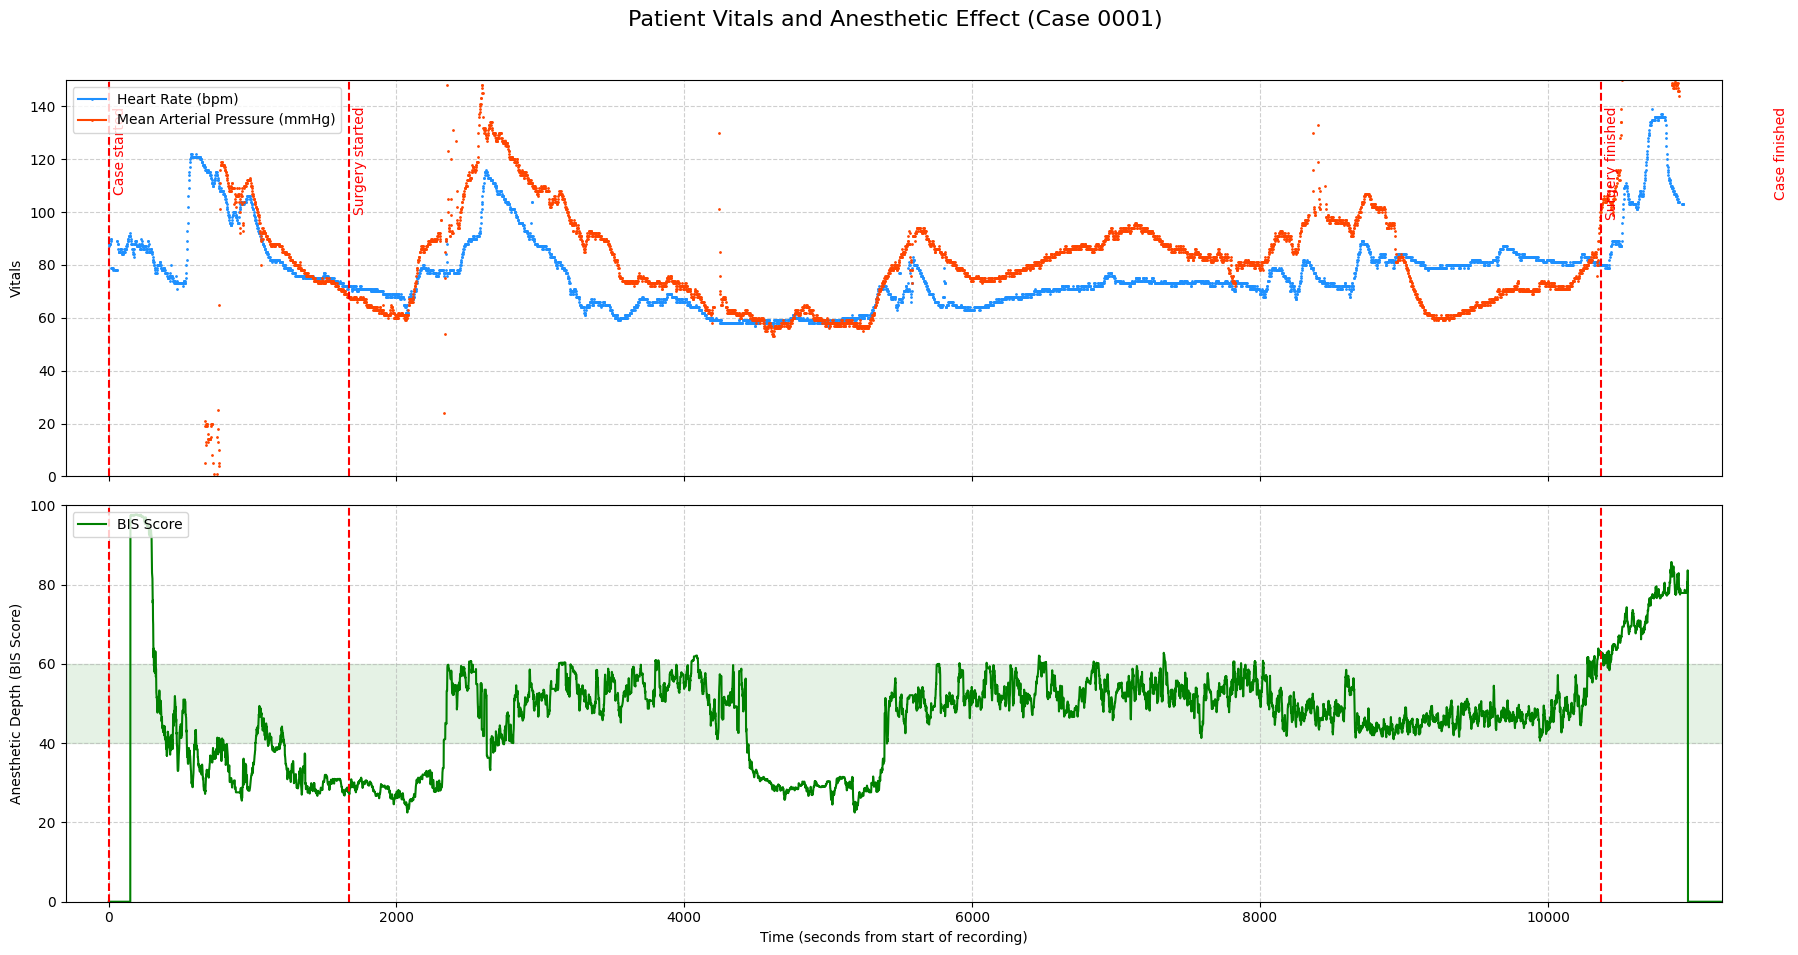

In [2]:
tracks_to_load = [
    'Solar8000/HR', 
    'Solar8000/ART_MBP', 
    'BIS/BIS',
    'EVENT'
]

vf = vitaldb.VitalFile(file_path)
df = vf.to_pandas(tracks_to_load, interval=1)

try:
    start_time = df['Solar8000/ART_MBP'].first_valid_index()
    end_time = df['Solar8000/ART_MBP'].last_valid_index()
    print(f"Data found between {start_time} and {end_time} seconds.")
except (KeyError, TypeError):
    print("Could not find valid data window. Plotting full range.")
    start_time = df.index.min()
    end_time = df.index.max()

events = df['EVENT'].dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
fig.suptitle('Patient Vitals and Anesthetic Effect (Case 0001)', fontsize=16)

ax1.plot(df.index, df['Solar8000/HR'], label='Heart Rate (bpm)', color='dodgerblue', marker='.', markersize=2, linestyle='-')
ax1.plot(df.index, df['Solar8000/ART_MBP'], label='Mean Arterial Pressure (mmHg)', color='orangered', marker='.', markersize=2, linestyle='-')
ax1.set_ylabel('Vitals')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_ylim(0, 150)

ax2.plot(df.index, df['BIS/BIS'], label='BIS Score', color='green')
ax2.set_xlabel('Time (seconds from start of recording)')
ax2.set_ylabel('Anesthetic Depth (BIS Score)')
ax2.legend(loc='upper left')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_ylim(0, 100) 
ax2.axhspan(40, 60, color='green', alpha=0.1, label='Target Anesthesia Range')


for time, text in events.items():
    ax1.axvline(x=time, color='red', linestyle='--', linewidth=1.5)
    ax2.axvline(x=time, color='red', linestyle='--', linewidth=1.5)
    ax1.text(time + 30, 140, text, rotation=90, verticalalignment='top', color='red', fontsize=10)

ax1.set_xlim(start_time - 300, end_time + 300)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

---
# more vitals

In [3]:
import numpy as np
import pandas as pd


file_path = '0001.vital'
vf = vitaldb.VitalFile(file_path)

input_vitals = [
    'Solar8000/HR', 
    'Solar8000/ART_MBP', 
    'Solar8000/PLETH_SPO2',
    'Solar8000/ETCO2'      
]
target_vital = 'BIS/BIS'
tracks_to_load = input_vitals + [target_vital]

df = vf.to_pandas(tracks_to_load, interval=1)
df_model = df.copy()


print("--- Feature Engineering for Regression ---")
window_size = 300  # 300 seconds = 5 minutes

def calculate_slope(y):
    y = y.dropna()
    if len(y) < 2: return 0
    return np.polyfit(np.arange(len(y)), y, 1)[0]

for col in input_vitals:
    print(f"Creating features for {col}...")
    df_model[f'{col}_mean'] = df_model[col].rolling(window=window_size).mean()
    df_model[f'{col}_std'] = df_model[col].rolling(window=window_size).std()
    df_model[f'{col}_min'] = df_model[col].rolling(window=window_size).min()
    df_model[f'{col}_max'] = df_model[col].rolling(window=window_size).max()
    df_model[f'{col}_trend'] = df_model[col].rolling(window=window_size).apply(calculate_slope, raw=False)

feature_cols = [col for col in df_model.columns if '_mean' in col or '_std' in col or '_min' in col or '_max' in col or '_trend' in col]
final_cols = feature_cols + [target_vital]
df_final = df_model[final_cols]

df_final = df_final.dropna()

print("\n--- Final Processed Data for Regression ---")
print(f"Shape of the final dataset: {df_final.shape}")
print("Columns in the final dataset:")
print(df_final.columns)
print("\nFirst 5 rows of the final training data:")
print(df_final.head())

--- Feature Engineering for Regression ---
Creating features for Solar8000/HR...
Creating features for Solar8000/ART_MBP...
Creating features for Solar8000/PLETH_SPO2...
Creating features for Solar8000/ETCO2...

--- Final Processed Data for Regression ---
Shape of the final dataset: (0, 21)
Columns in the final dataset:
Index(['Solar8000/HR_mean', 'Solar8000/HR_std', 'Solar8000/HR_min',
       'Solar8000/HR_max', 'Solar8000/HR_trend', 'Solar8000/ART_MBP_mean',
       'Solar8000/ART_MBP_std', 'Solar8000/ART_MBP_min',
       'Solar8000/ART_MBP_max', 'Solar8000/ART_MBP_trend',
       'Solar8000/PLETH_SPO2_mean', 'Solar8000/PLETH_SPO2_std',
       'Solar8000/PLETH_SPO2_min', 'Solar8000/PLETH_SPO2_max',
       'Solar8000/PLETH_SPO2_trend', 'Solar8000/ETCO2_mean',
       'Solar8000/ETCO2_std', 'Solar8000/ETCO2_min', 'Solar8000/ETCO2_max',
       'Solar8000/ETCO2_trend', 'BIS/BIS'],
      dtype='object')

First 5 rows of the final training data:
Empty DataFrame
Columns: [Solar8000/HR_mean, So

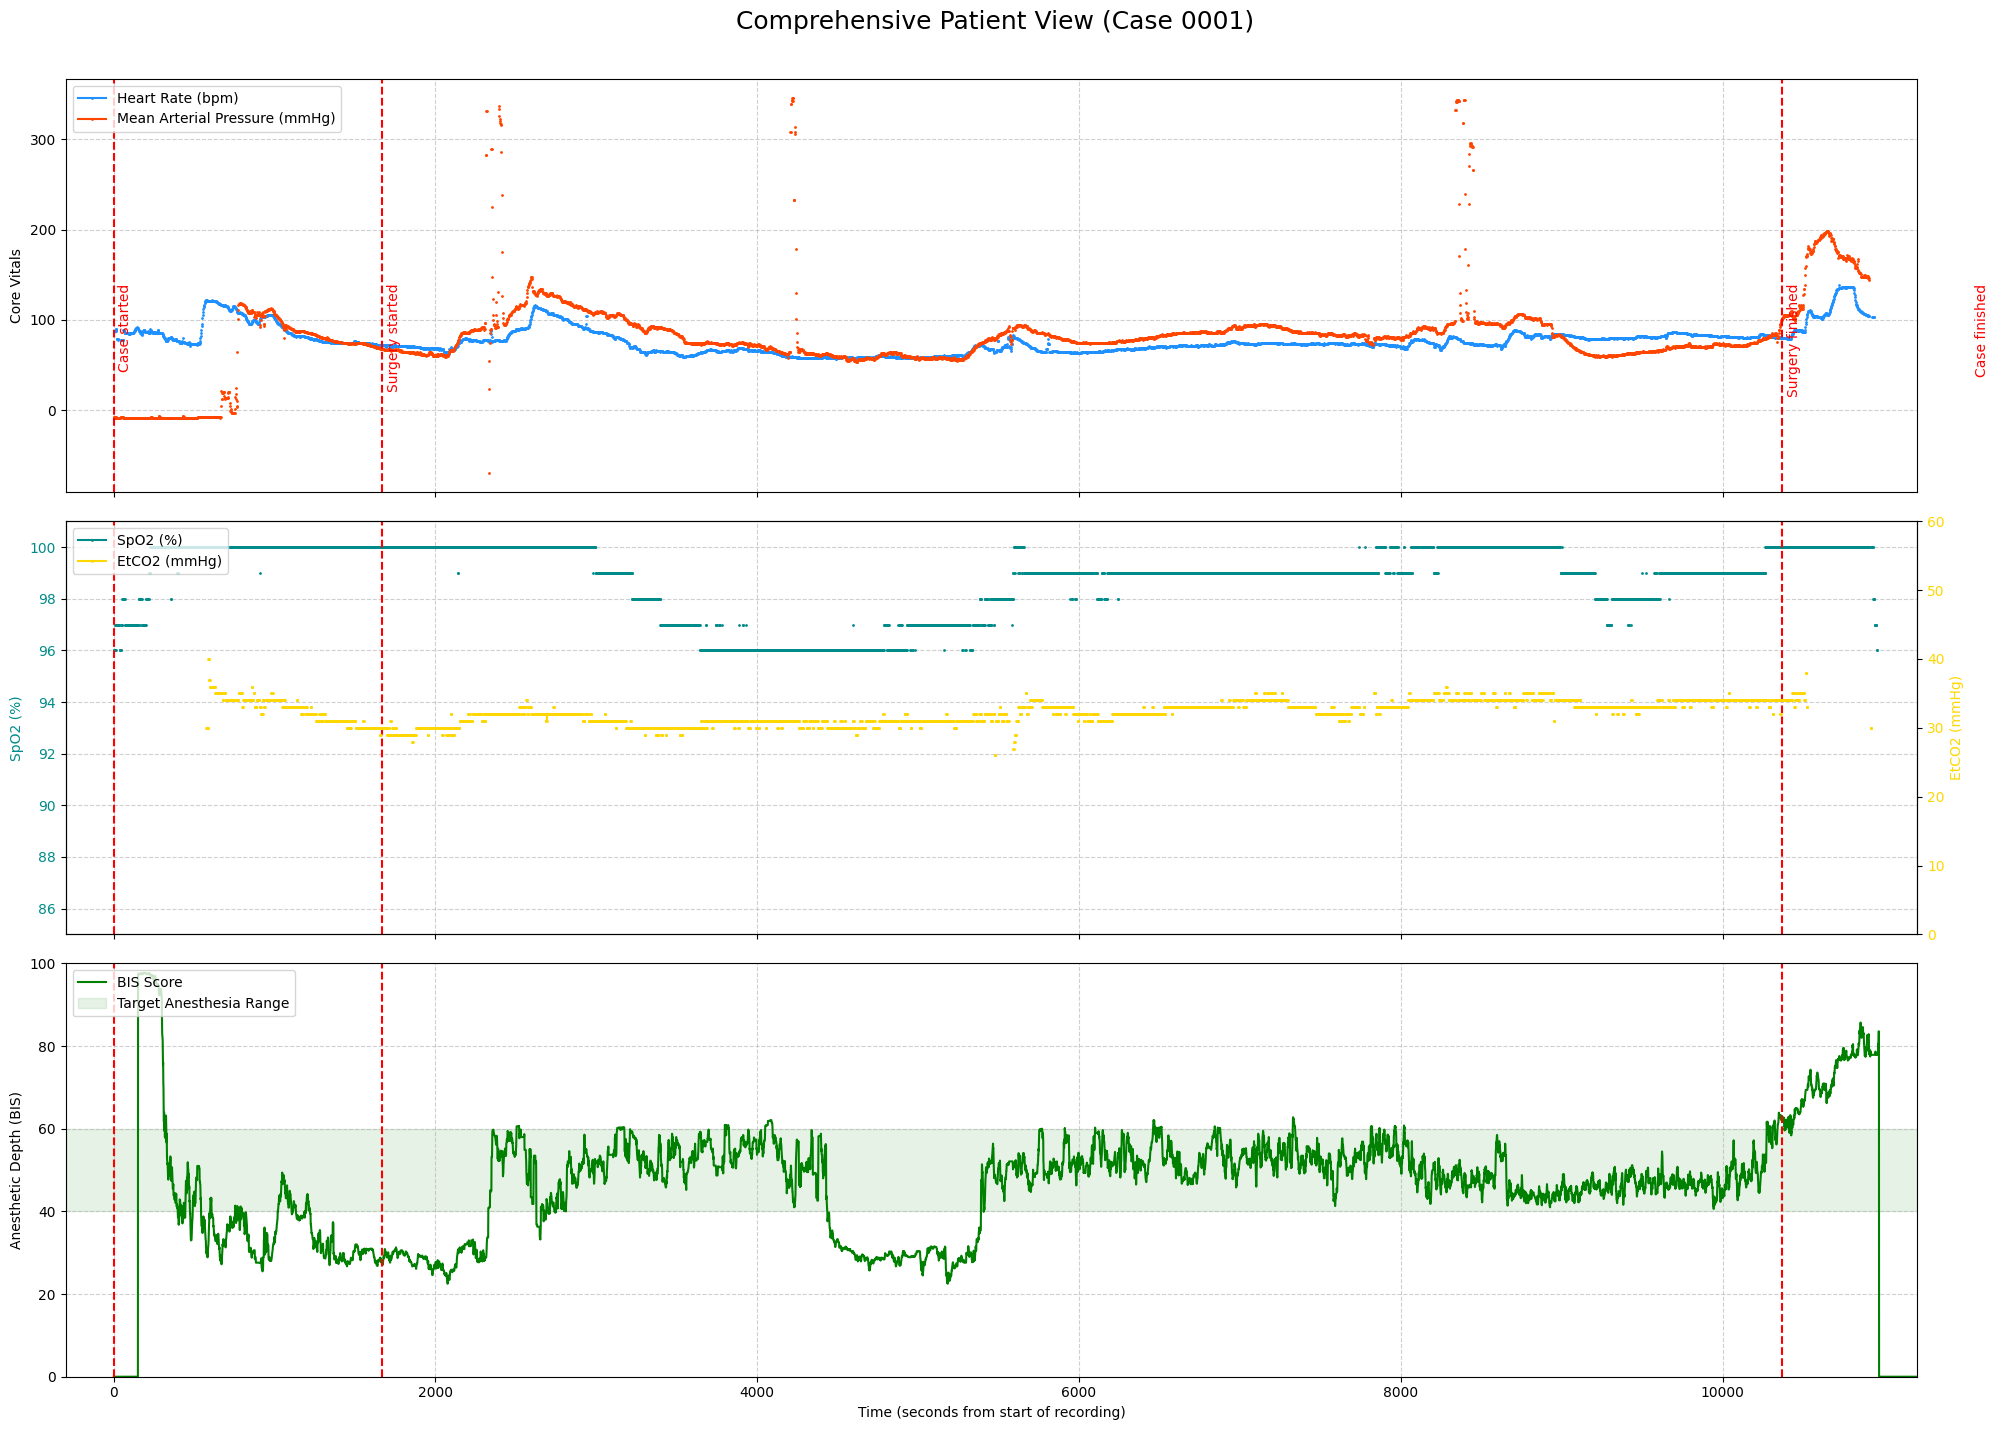

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

tracks_to_load = [
    'Solar8000/HR', 
    'Solar8000/ART_MBP', 
    'Solar8000/PLETH_SPO2',
    'Solar8000/ETCO2',
    'BIS/BIS',
    'EVENT'
]

file_path = '0001.vital'
vf = vitaldb.VitalFile(file_path)
df = vf.to_pandas(tracks_to_load, interval=1)

try:
    start_time = df['Solar8000/ART_MBP'].first_valid_index()
    end_time = df['Solar8000/ART_MBP'].last_valid_index()
except (KeyError, TypeError):
    start_time, end_time = df.index.min(), df.index.max()

events = df['EVENT'].dropna()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), sharex=True)
fig.suptitle('Comprehensive Patient View (Case 0001)', fontsize=18)

ax1.plot(df.index, df['Solar8000/HR'], label='Heart Rate (bpm)', color='dodgerblue', marker='.', markersize=2, linestyle='-')
ax1.plot(df.index, df['Solar8000/ART_MBP'], label='Mean Arterial Pressure (mmHg)', color='orangered', marker='.', markersize=2, linestyle='-')
ax1.set_ylabel('Core Vitals')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.6)

ax2.plot(df.index, df['Solar8000/PLETH_SPO2'], label='SpO2 (%)', color='darkcyan', marker='.', markersize=2, linestyle='-')
ax2.set_ylabel('SpO2 (%)', color='darkcyan')
ax2.tick_params(axis='y', labelcolor='darkcyan')
ax2.set_ylim(85, 101)

ax2_twin = ax2.twinx()
ax2_twin.plot(df.index, df['Solar8000/ETCO2'], label='EtCO2 (mmHg)', color='gold', marker='.', markersize=2, linestyle='-')
ax2_twin.set_ylabel('EtCO2 (mmHg)', color='gold')
ax2_twin.tick_params(axis='y', labelcolor='gold')
ax2_twin.set_ylim(0, 60) 

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2_twin.legend(lines + lines2, labels + labels2, loc='upper left')
ax2.grid(True, linestyle='--', alpha=0.6)

ax3.plot(df.index, df['BIS/BIS'], label='BIS Score', color='green')
ax3.axhspan(40, 60, color='green', alpha=0.1, label='Target Anesthesia Range')
ax3.set_xlabel('Time (seconds from start of recording)')
ax3.set_ylabel('Anesthetic Depth (BIS)')
ax3.legend(loc='upper left')
ax3.grid(True, linestyle='--', alpha=0.6)
ax3.set_ylim(0, 100)

for time, text in events.items():
    for ax in [ax1, ax2, ax3]:
        ax.axvline(x=time, color='red', linestyle='--', linewidth=1.5)
    ax1.text(time + 30, 140, text, rotation=90, verticalalignment='top', color='red', fontsize=10)

ax1.set_xlim(start_time - 300, end_time + 300)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [5]:
import numpy as np
import pandas as pd

file_path = '0001.vital'
vf = vitaldb.VitalFile(file_path)

input_vitals = [
    'Solar8000/HR', 
    'Solar8000/ART_MBP', 
    'Solar8000/PLETH_SPO2',
    'Solar8000/ETCO2'
]
target_vital = 'BIS/BIS'
tracks_to_load = input_vitals + [target_vital]

df = vf.to_pandas(tracks_to_load, interval=1)
df_model = df.copy()

print("--- Imputing missing values in input vitals using forward-fill... ---")
df_model[input_vitals] = df_model[input_vitals].ffill()

print("--- Feature Engineering for Regression... ---")
window_size = 300  

def calculate_slope(y):
    y = y.dropna()
    if len(y) < 2: return 0
    return np.polyfit(np.arange(len(y)), y, 1)[0]

for col in input_vitals:
    print(f"Creating features for {col}...")
    df_model[f'{col}_mean'] = df_model[col].rolling(window=window_size, min_periods=1).mean()
    df_model[f'{col}_std'] = df_model[col].rolling(window=window_size, min_periods=1).std()
    df_model[f'{col}_min'] = df_model[col].rolling(window=window_size, min_periods=1).min()
    df_model[f'{col}_max'] = df_model[col].rolling(window=window_size, min_periods=1).max()
    df_model[f'{col}_trend'] = df_model[col].rolling(window=window_size, min_periods=1).apply(calculate_slope, raw=False)

feature_cols = [col for col in df_model.columns if '_mean' in col or '_std' in col or '_min' in col or '_max' in col or '_trend' in col]
target_col = [target_vital]
df_final = df_model[feature_cols + target_col]

df_final = df_final.dropna()

df_final = df_final.fillna(0)

print("\n--- Final Processed Data for Regression ---")
print(f"Shape of the final dataset: {df_final.shape}")
print("\nFirst 5 rows of the final training data:")
print(df_final.head())

--- Imputing missing values in input vitals using forward-fill... ---
--- Feature Engineering for Regression... ---
Creating features for Solar8000/HR...
Creating features for Solar8000/ART_MBP...
Creating features for Solar8000/PLETH_SPO2...
Creating features for Solar8000/ETCO2...

--- Final Processed Data for Regression ---
Shape of the final dataset: (10964, 21)

First 5 rows of the final training data:
     Solar8000/HR_mean  Solar8000/HR_std  Solar8000/HR_min  Solar8000/HR_max  \
577          80.900000         11.647412              71.0             122.0   
578          81.013333         11.879826              71.0             122.0   
579          81.126667         12.106714              71.0             122.0   
580          81.243333         12.320584              71.0             122.0   
581          81.360000         12.529713              71.0             122.0   

     Solar8000/HR_trend  Solar8000/ART_MBP_mean  Solar8000/ART_MBP_std  \
577            0.036807           

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

X = df_final.drop(columns=[target_vital])
y = df_final[target_vital]

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("\nTraining the model...")
model.fit(X_train, y_train)
print("Training complete.")

print("\nMaking predictions on the test set...")
y_pred = model.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n--- Model Evaluation ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"This means our model's BIS score predictions are, on average, off by {rmse:.2f} points.")

test_predictions = pd.Series(y_pred, index=y_test.index, name='Predicted_BIS')

Training set size: 8771 samples
Testing set size: 2193 samples

Training the model...
Training complete.

Making predictions on the test set...

--- Model Evaluation ---
Root Mean Squared Error (RMSE): 31.82
This means our model's BIS score predictions are, on average, off by 31.82 points.


/tmp/ipykernel_20/1550845416.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model[input_vitals] = df_model[input_vitals].ffill()
/tmp/ipykernel_20/1550845416.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final = df_model[feature_cols + [target_vital]].dropna().fillna(0)


Root Mean Squared Error (RMSE): 31.82

--- Generating plot for Case 1 with predictions ---


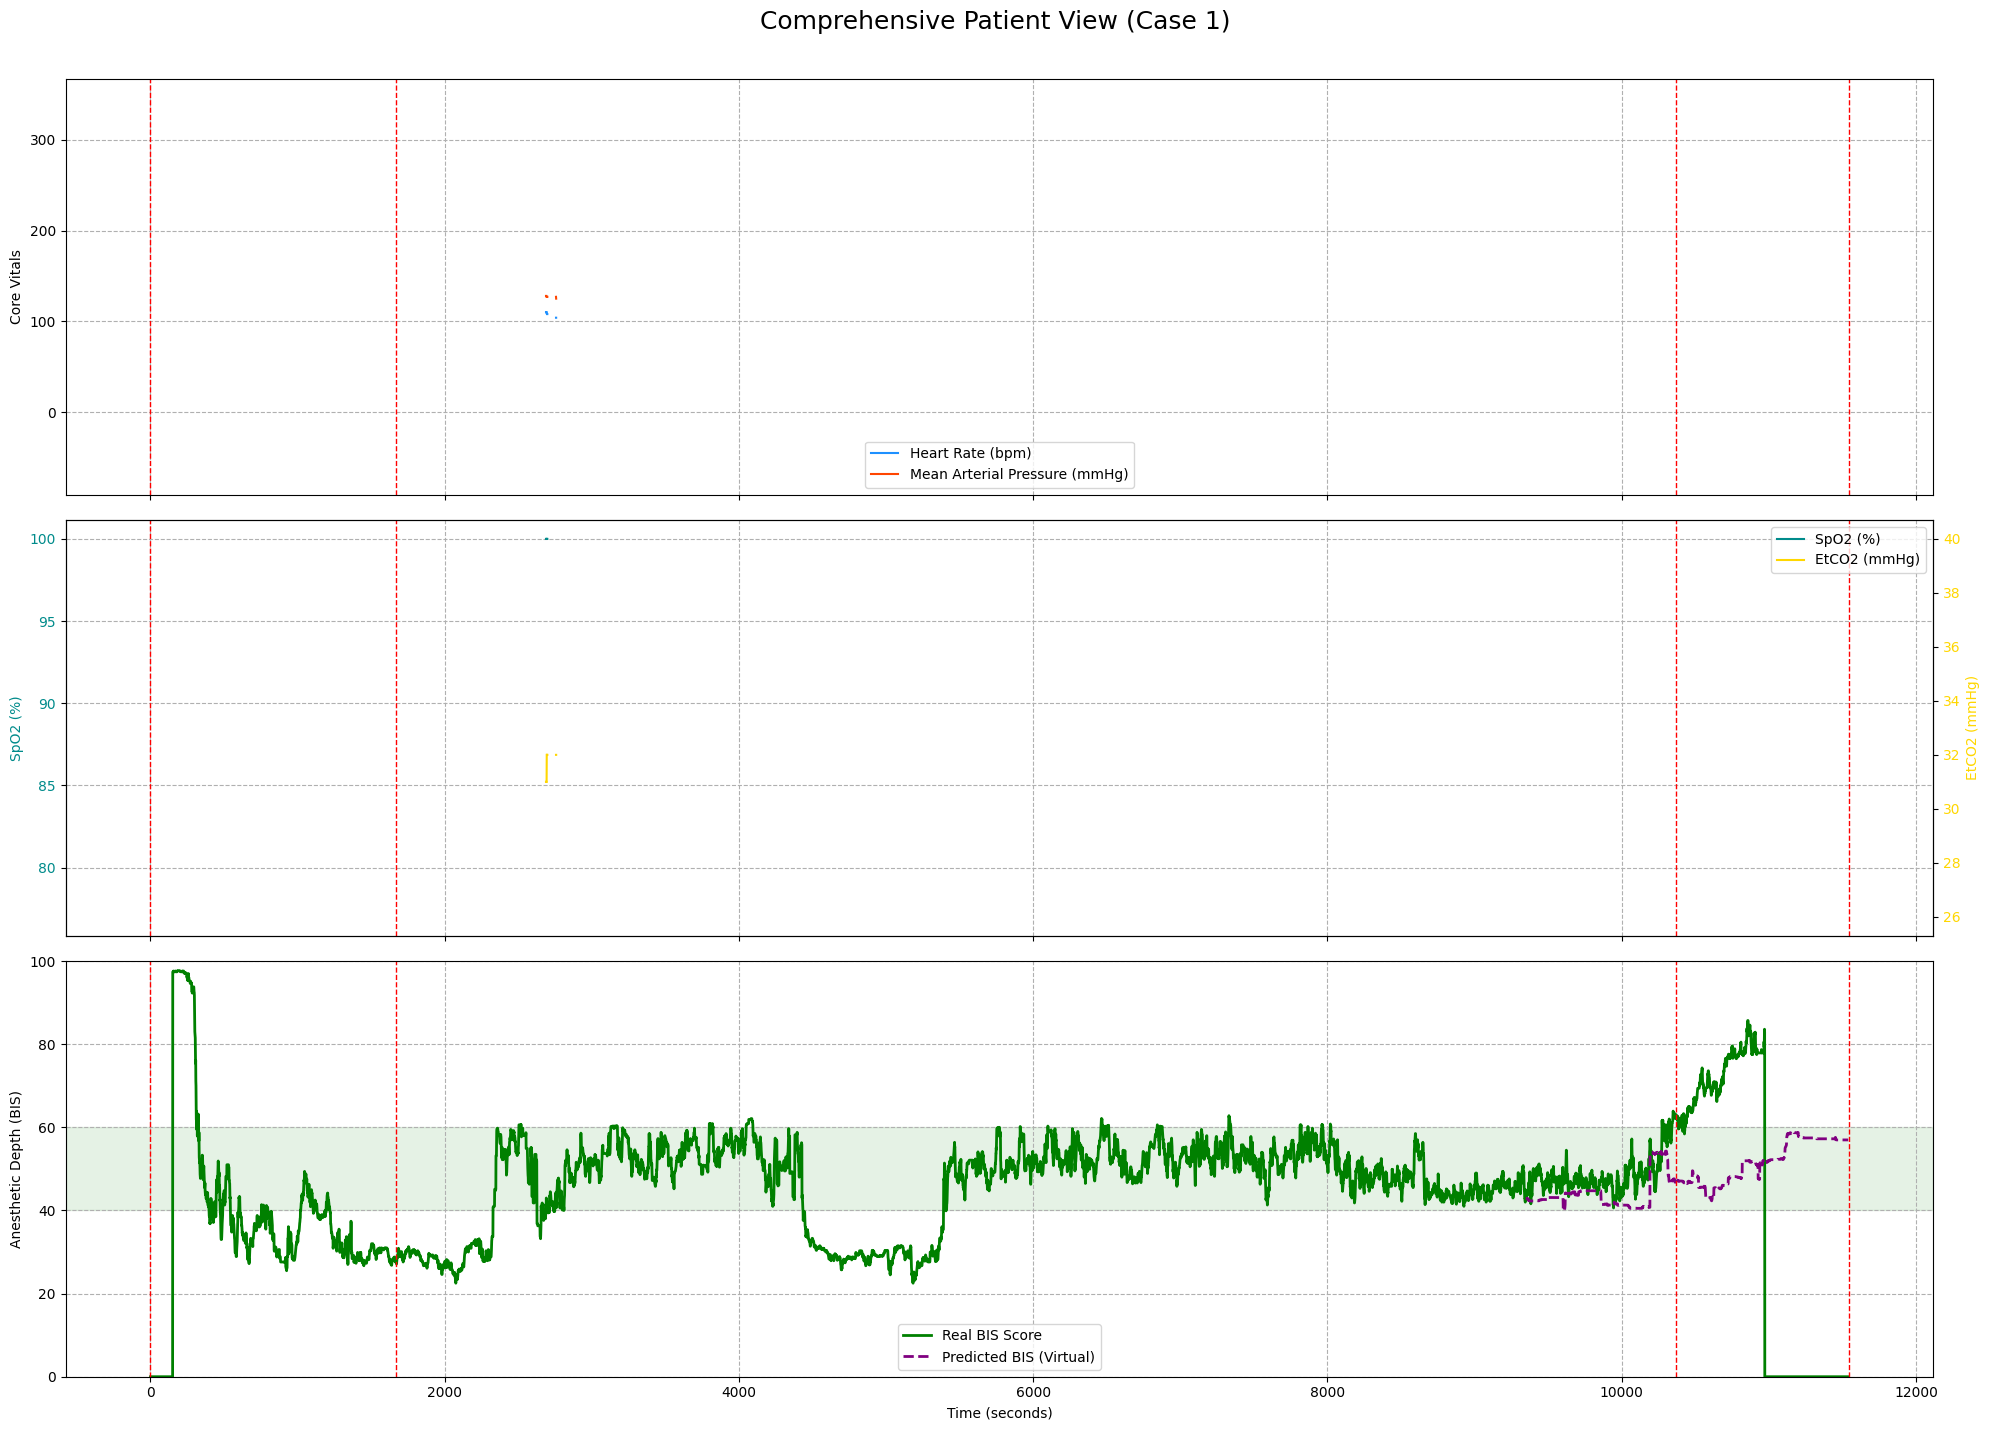

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import pandas as pd

file_path = '0001.vital'
vf = vitaldb.VitalFile(file_path)

input_vitals = ['Solar8000/HR', 'Solar8000/ART_MBP', 'Solar8000/PLETH_SPO2', 'Solar8000/ETCO2']
target_vital = 'BIS/BIS'
event_track = 'EVENT' 

df_full = vf.to_pandas(input_vitals + [target_vital, event_track], interval=1)

df_model = df_full.copy()
df_model[input_vitals] = df_model[input_vitals].ffill()
window_size = 300
for col in input_vitals:
    df_model[f'{col}_mean'] = df_model[col].rolling(window=window_size, min_periods=1).mean()
    df_model[f'{col}_std'] = df_model[col].rolling(window=window_size, min_periods=1).std()
    df_model[f'{col}_min'] = df_model[col].rolling(window=window_size, min_periods=1).min()
    df_model[f'{col}_max'] = df_model[col].rolling(window=window_size, min_periods=1).max()
    df_model[f'{col}_trend'] = df_model[col].rolling(window=window_size, min_periods=1).apply(lambda y: np.polyfit(np.arange(len(y.dropna())), y.dropna(), 1)[0] if len(y.dropna()) > 1 else 0, raw=False)

feature_cols = [col for col in df_model.columns if '_mean' in col or '_std' in col or '_min' in col or '_max' in col or '_trend' in col]
df_final = df_model[feature_cols + [target_vital]].dropna().fillna(0)

X = df_final.drop(columns=[target_vital])
y = df_final[target_vital]
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
test_predictions = pd.Series(y_pred, index=y_test.index, name='Predicted_BIS')

def plot_case_with_prediction(case_id, df_plot, predictions):
    print(f"\n--- Generating plot for Case {case_id} with predictions ---")
    events = df_plot['EVENT'].dropna()
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), sharex=True)
    fig.suptitle(f'Comprehensive Patient View (Case {case_id})', fontsize=18)

    ax1.plot(df_plot.index, df_plot['Solar8000/HR'], label='Heart Rate (bpm)', color='dodgerblue')
    ax1.plot(df_plot.index, df_plot['Solar8000/ART_MBP'], label='Mean Arterial Pressure (mmHg)', color='orangered')
    ax1.set_ylabel('Core Vitals')
    ax1.legend(); ax1.grid(True, linestyle='--')

    ax2.plot(df_plot.index, df_plot['Solar8000/PLETH_SPO2'], label='SpO2 (%)', color='darkcyan')
    ax2.set_ylabel('SpO2 (%)', color='darkcyan'); ax2.tick_params(axis='y', labelcolor='darkcyan')
    ax2_twin = ax2.twinx()
    ax2_twin.plot(df_plot.index, df_plot['Solar8000/ETCO2'], label='EtCO2 (mmHg)', color='gold')
    ax2_twin.set_ylabel('EtCO2 (mmHg)', color='gold'); ax2_twin.tick_params(axis='y', labelcolor='gold')
    lines, labels = ax2.get_legend_handles_labels(); lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2_twin.legend(lines + lines2, labels + labels2); ax2.grid(True, linestyle='--')

    ax3.plot(df_plot.index, df_plot['BIS/BIS'], label='Real BIS Score', color='green', linewidth=2)
    ax3.plot(predictions.index, predictions, label='Predicted BIS (Virtual)', color='purple', linestyle='--', linewidth=2)
    ax3.axhspan(40, 60, color='green', alpha=0.1)
    ax3.set_xlabel('Time (seconds)'); ax3.set_ylabel('Anesthetic Depth (BIS)'); ax3.legend(); ax3.grid(True, linestyle='--'); ax3.set_ylim(0, 100)

    for time, text in events.items():
        for ax in [ax1, ax2, ax3]: ax.axvline(x=time, color='red', linestyle='--', linewidth=1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]); plt.show()

plot_case_with_prediction(case_id=1, df_plot=df_full, predictions=test_predictions)

# adding parameters to visualize
- Primus/SET_AGE
- Primus/INSP_SEVO
- Primus/EXP_SEVOPrimus/INSP_DES
- Primus/EXP_DES
- Primus/SET_AGE

download: s3://physionet-open/vitaldb/1.0.0/vital_files/0001.vital to ./0001.vital
Data found between 2 and 10911 seconds.


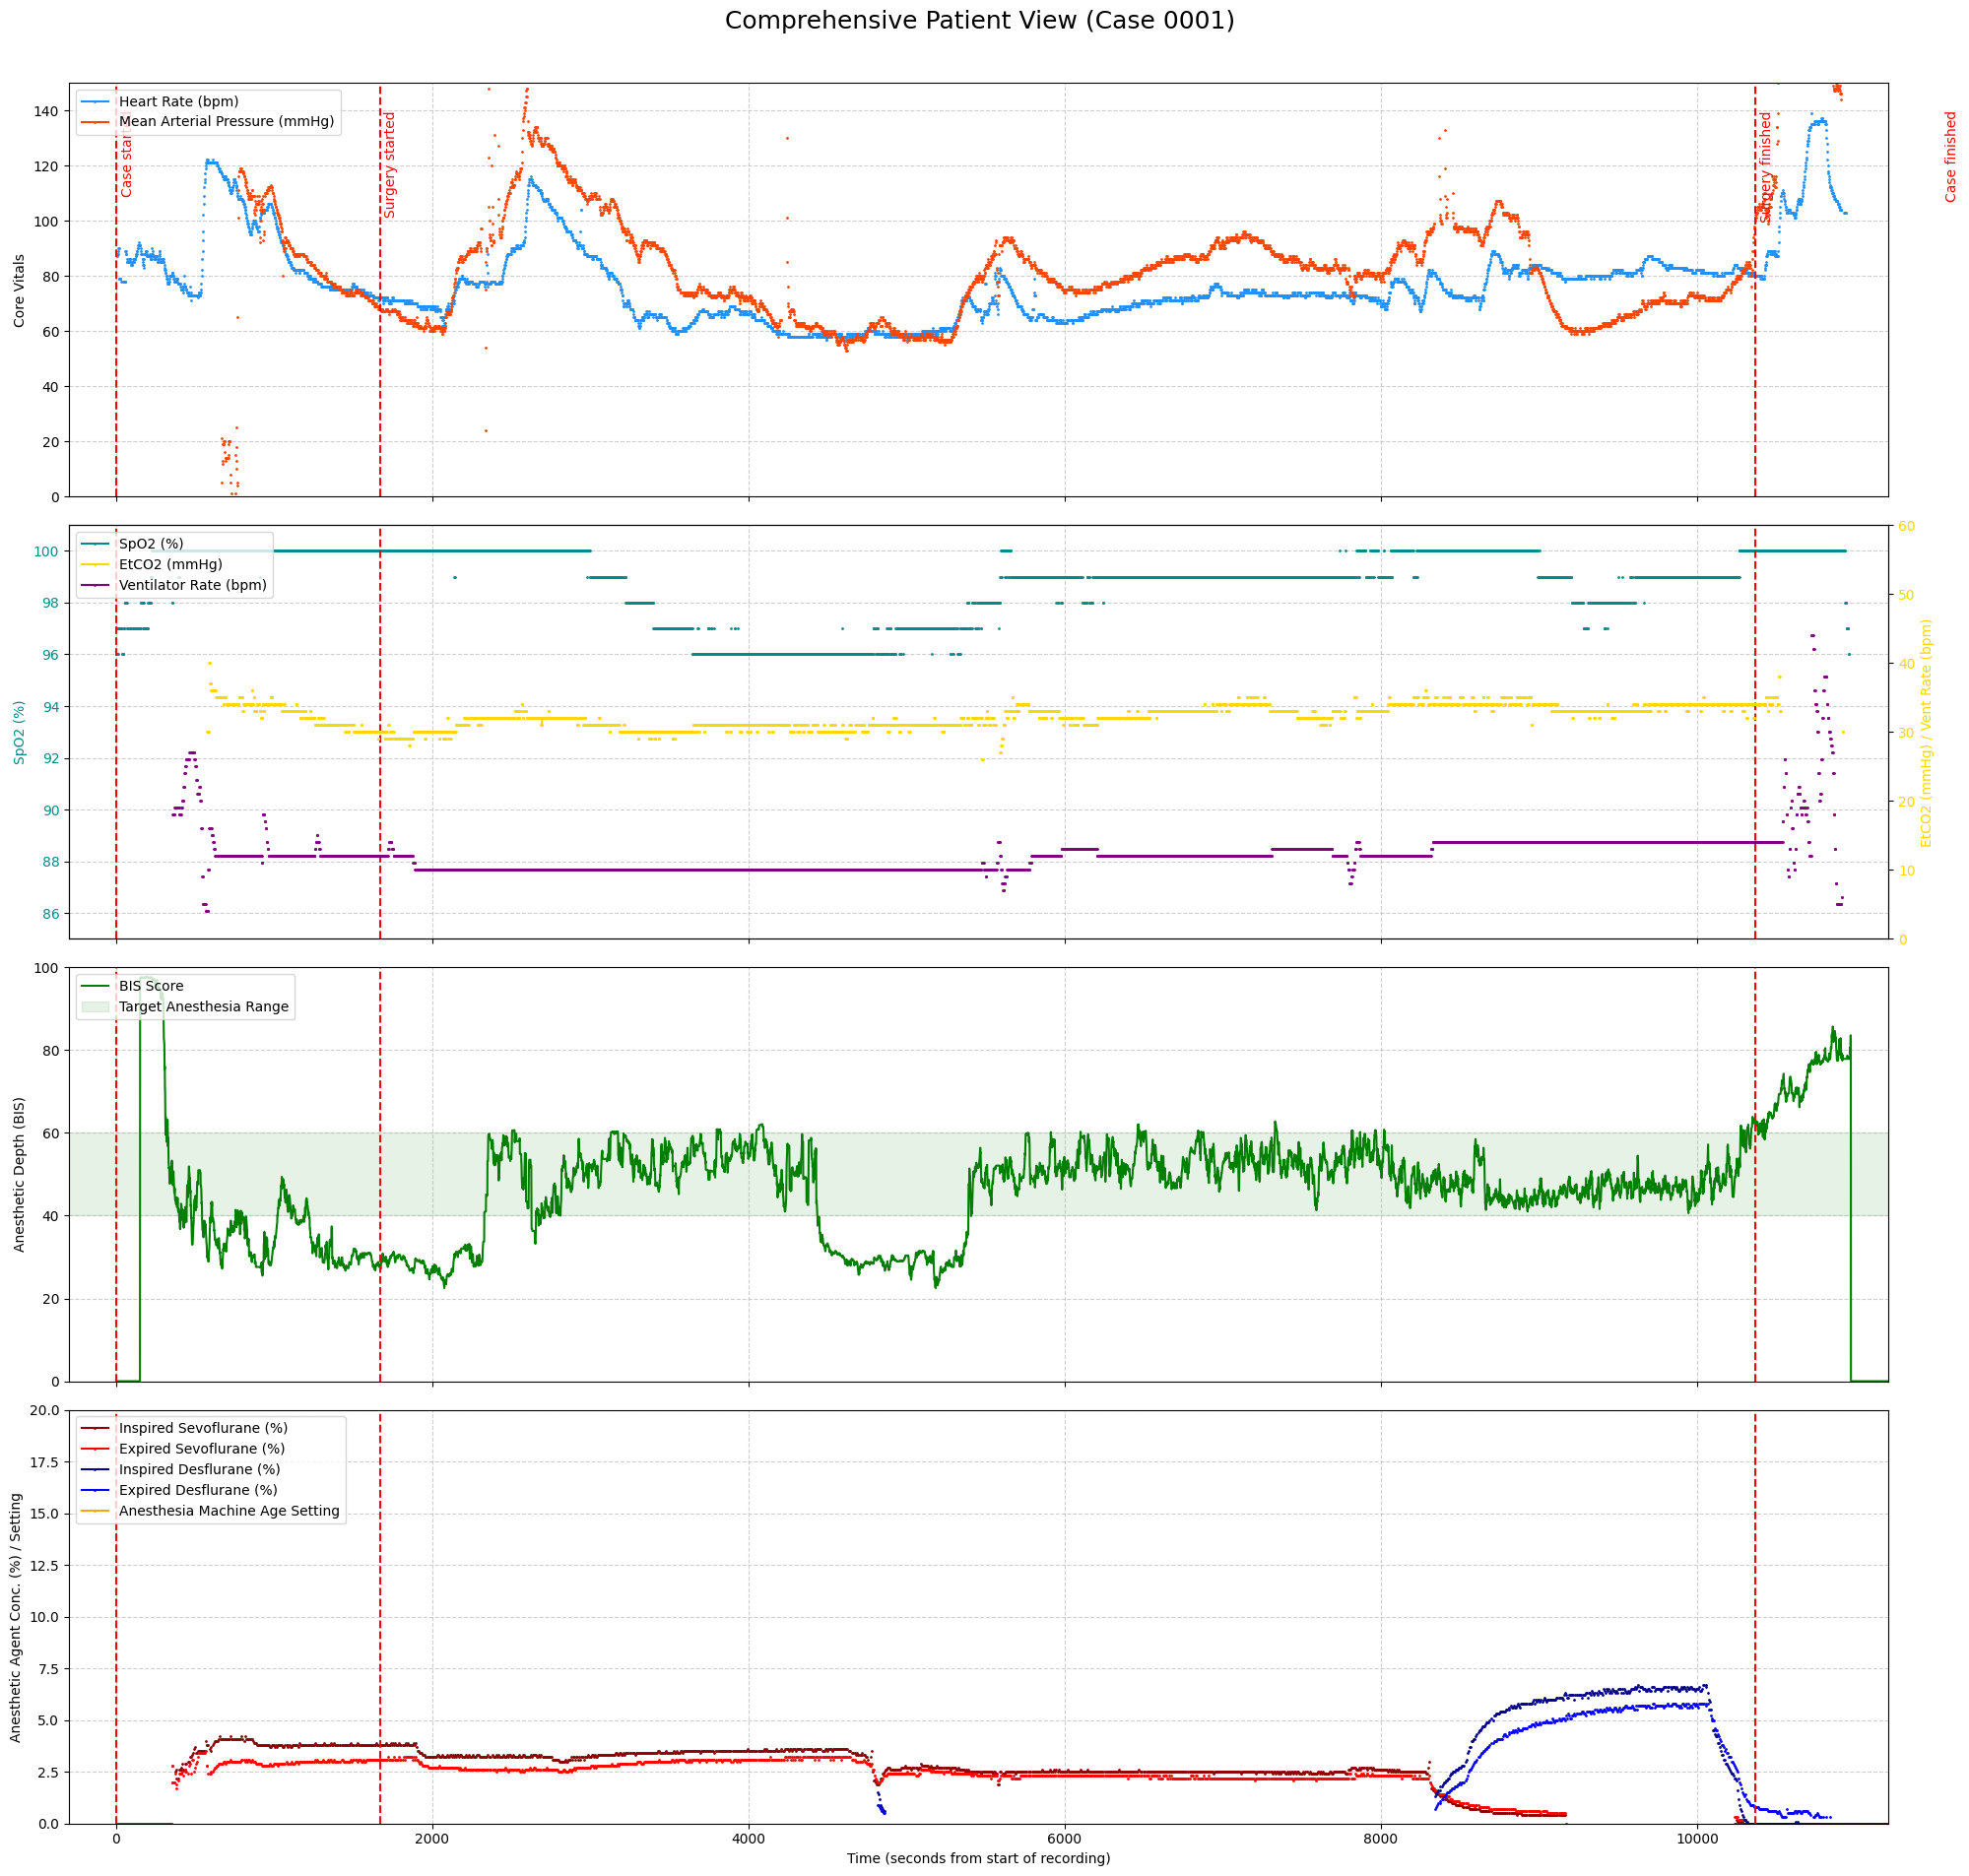

In [8]:
!pip install vitaldb matplotlib awscli --quiet

import vitaldb
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np # Added for potential future use, though not strictly needed for this plot

# Clean up previous download and re-download the file
!rm -f 0001.vital
!aws s3 cp --no-sign-request s3://physionet-open/vitaldb/1.0.0/vital_files/0001.vital .

file_path = '0001.vital'
if os.path.exists(file_path):
    vf = vitaldb.VitalFile(file_path)

    # Define all tracks to load, including the newly requested ones
    tracks_to_load = [
        'Solar8000/HR',
        'Solar8000/ART_MBP',
        'Solar8000/PLETH_SPO2',
        'Solar8000/ETCO2',
        'Solar8000/VENT_RR',  # Added
        'BIS/BIS',
        'Primus/INSP_SEVO',  # Added
        'Primus/EXP_SEVO',   # Added
        'Primus/INSP_DES',   # Added (corrected)
        'Primus/EXP_DES',    # Added (corrected)
        'Primus/SET_AGE',    # Added
        'EVENT'
    ]

    # Load data into a Pandas DataFrame
    df = vf.to_pandas(tracks_to_load, interval=1)

    # Determine the plotting time range
    try:
        # Use ART_MBP as a reference for valid data range
        start_time = df['Solar8000/ART_MBP'].first_valid_index()
        end_time = df['Solar8000/ART_MBP'].last_valid_index()
        if start_time is None or end_time is None: # Fallback if ART_MBP is entirely NaN
            start_time, end_time = df.index.min(), df.index.max()
        print(f"Data found between {start_time} and {end_time} seconds.")
    except (KeyError, TypeError):
        print("Could not find valid data window for ART_MBP. Plotting full range.")
        start_time = df.index.min()
        end_time = df.index.max()

    # Extract events
    events = df['EVENT'].dropna()

    # Create the figure and 4 subplots, sharing the x-axis
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 20), sharex=True)
    fig.suptitle('Comprehensive Patient View (Case 0001)', fontsize=18)

    # --- Subplot 1: Core Vitals (HR, MAP) ---
    ax1.plot(df.index, df['Solar8000/HR'], label='Heart Rate (bpm)', color='dodgerblue', marker='.', markersize=2, linestyle='-')
    ax1.plot(df.index, df['Solar8000/ART_MBP'], label='Mean Arterial Pressure (mmHg)', color='orangered', marker='.', markersize=2, linestyle='-')
    ax1.set_ylabel('Core Vitals')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_ylim(0, 150) # Consistent Y-limit for vitals

    # --- Subplot 2: Oxygenation and Ventilation (SpO2, EtCO2, VENT_RR) ---
    ax2.plot(df.index, df['Solar8000/PLETH_SPO2'], label='SpO2 (%)', color='darkcyan', marker='.', markersize=2, linestyle='-')
    ax2.set_ylabel('SpO2 (%)', color='darkcyan')
    ax2.tick_params(axis='y', labelcolor='darkcyan')
    ax2.set_ylim(85, 101) # Typical SpO2 range

    ax2_twin = ax2.twinx() # Create a twin Y-axis for EtCO2 and VENT_RR
    ax2_twin.plot(df.index, df['Solar8000/ETCO2'], label='EtCO2 (mmHg)', color='gold', marker='.', markersize=2, linestyle='-')
    ax2_twin.plot(df.index, df['Solar8000/VENT_RR'], label='Ventilator Rate (bpm)', color='purple', marker='.', markersize=2, linestyle='-') # Added VENT_RR
    ax2_twin.set_ylabel('EtCO2 (mmHg) / Vent Rate (bpm)', color='gold') # Combined label
    ax2_twin.tick_params(axis='y', labelcolor='gold')
    ax2_twin.set_ylim(0, 60) # Consistent Y-limit for EtCO2/Vent Rate

    # Combine legends for ax2 and ax2_twin
    lines, labels = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2_twin.legend(lines + lines2, labels + labels2, loc='upper left')
    ax2.grid(True, linestyle='--', alpha=0.6)

    # --- Subplot 3: Anesthetic Depth (BIS) ---
    ax3.plot(df.index, df['BIS/BIS'], label='BIS Score', color='green')
    ax3.axhspan(40, 60, color='green', alpha=0.1, label='Target Anesthesia Range') # Shaded target range
    ax3.set_ylabel('Anesthetic Depth (BIS)')
    ax3.legend(loc='upper left')
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.set_ylim(0, 100) # BIS score range

    # --- Subplot 4: Anesthetic Agents (Sevoflurane, Desflurane, Age Setting) ---
    ax4.plot(df.index, df['Primus/INSP_SEVO'], label='Inspired Sevoflurane (%)', color='darkred', marker='.', markersize=2, linestyle='-')
    ax4.plot(df.index, df['Primus/EXP_SEVO'], label='Expired Sevoflurane (%)', color='red', marker='.', markersize=2, linestyle='-')
    ax4.plot(df.index, df['Primus/INSP_DES'], label='Inspired Desflurane (%)', color='darkblue', marker='.', markersize=2, linestyle='-') # Added
    ax4.plot(df.index, df['Primus/EXP_DES'], label='Expired Desflurane (%)', color='blue', marker='.', markersize=2, linestyle='-') # Added
    ax4.plot(df.index, df['Primus/SET_AGE'], label='Anesthesia Machine Age Setting', color='orange', marker='.', markersize=2, linestyle='-') # Added
    ax4.set_xlabel('Time (seconds from start of recording)')
    ax4.set_ylabel('Anesthetic Agent Conc. (%) / Setting')
    ax4.legend(loc='upper left')
    ax4.grid(True, linestyle='--', alpha=0.6)
    ax4.set_ylim(0, 20) # Adjusted Y-limit to accommodate desflurane (can go higher than sevoflurane)

    # --- Add Event Markers to all subplots ---
    for time, text in events.items():
        for ax in [ax1, ax2, ax3, ax4]: # Apply to all 4 subplots
            ax.axvline(x=time, color='red', linestyle='--', linewidth=1.5)
        # Place text annotation only on the top subplot for clarity
        ax1.text(time + 30, 140, text, rotation=90, verticalalignment='top', color='red', fontsize=10)

    # Set consistent x-axis limits for all subplots
    ax1.set_xlim(start_time - 300, end_time + 300)

    # Adjust layout to prevent overlapping elements
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust rect to make space for the main title
    plt.show()

else:
    print(f"ERROR: Download failed. File '{file_path}' not found.")

# aesthetic enhancements

download: s3://physionet-open/vitaldb/1.0.0/vital_files/0001.vital to ./0001.vital
Data found between 2 and 10911 seconds.


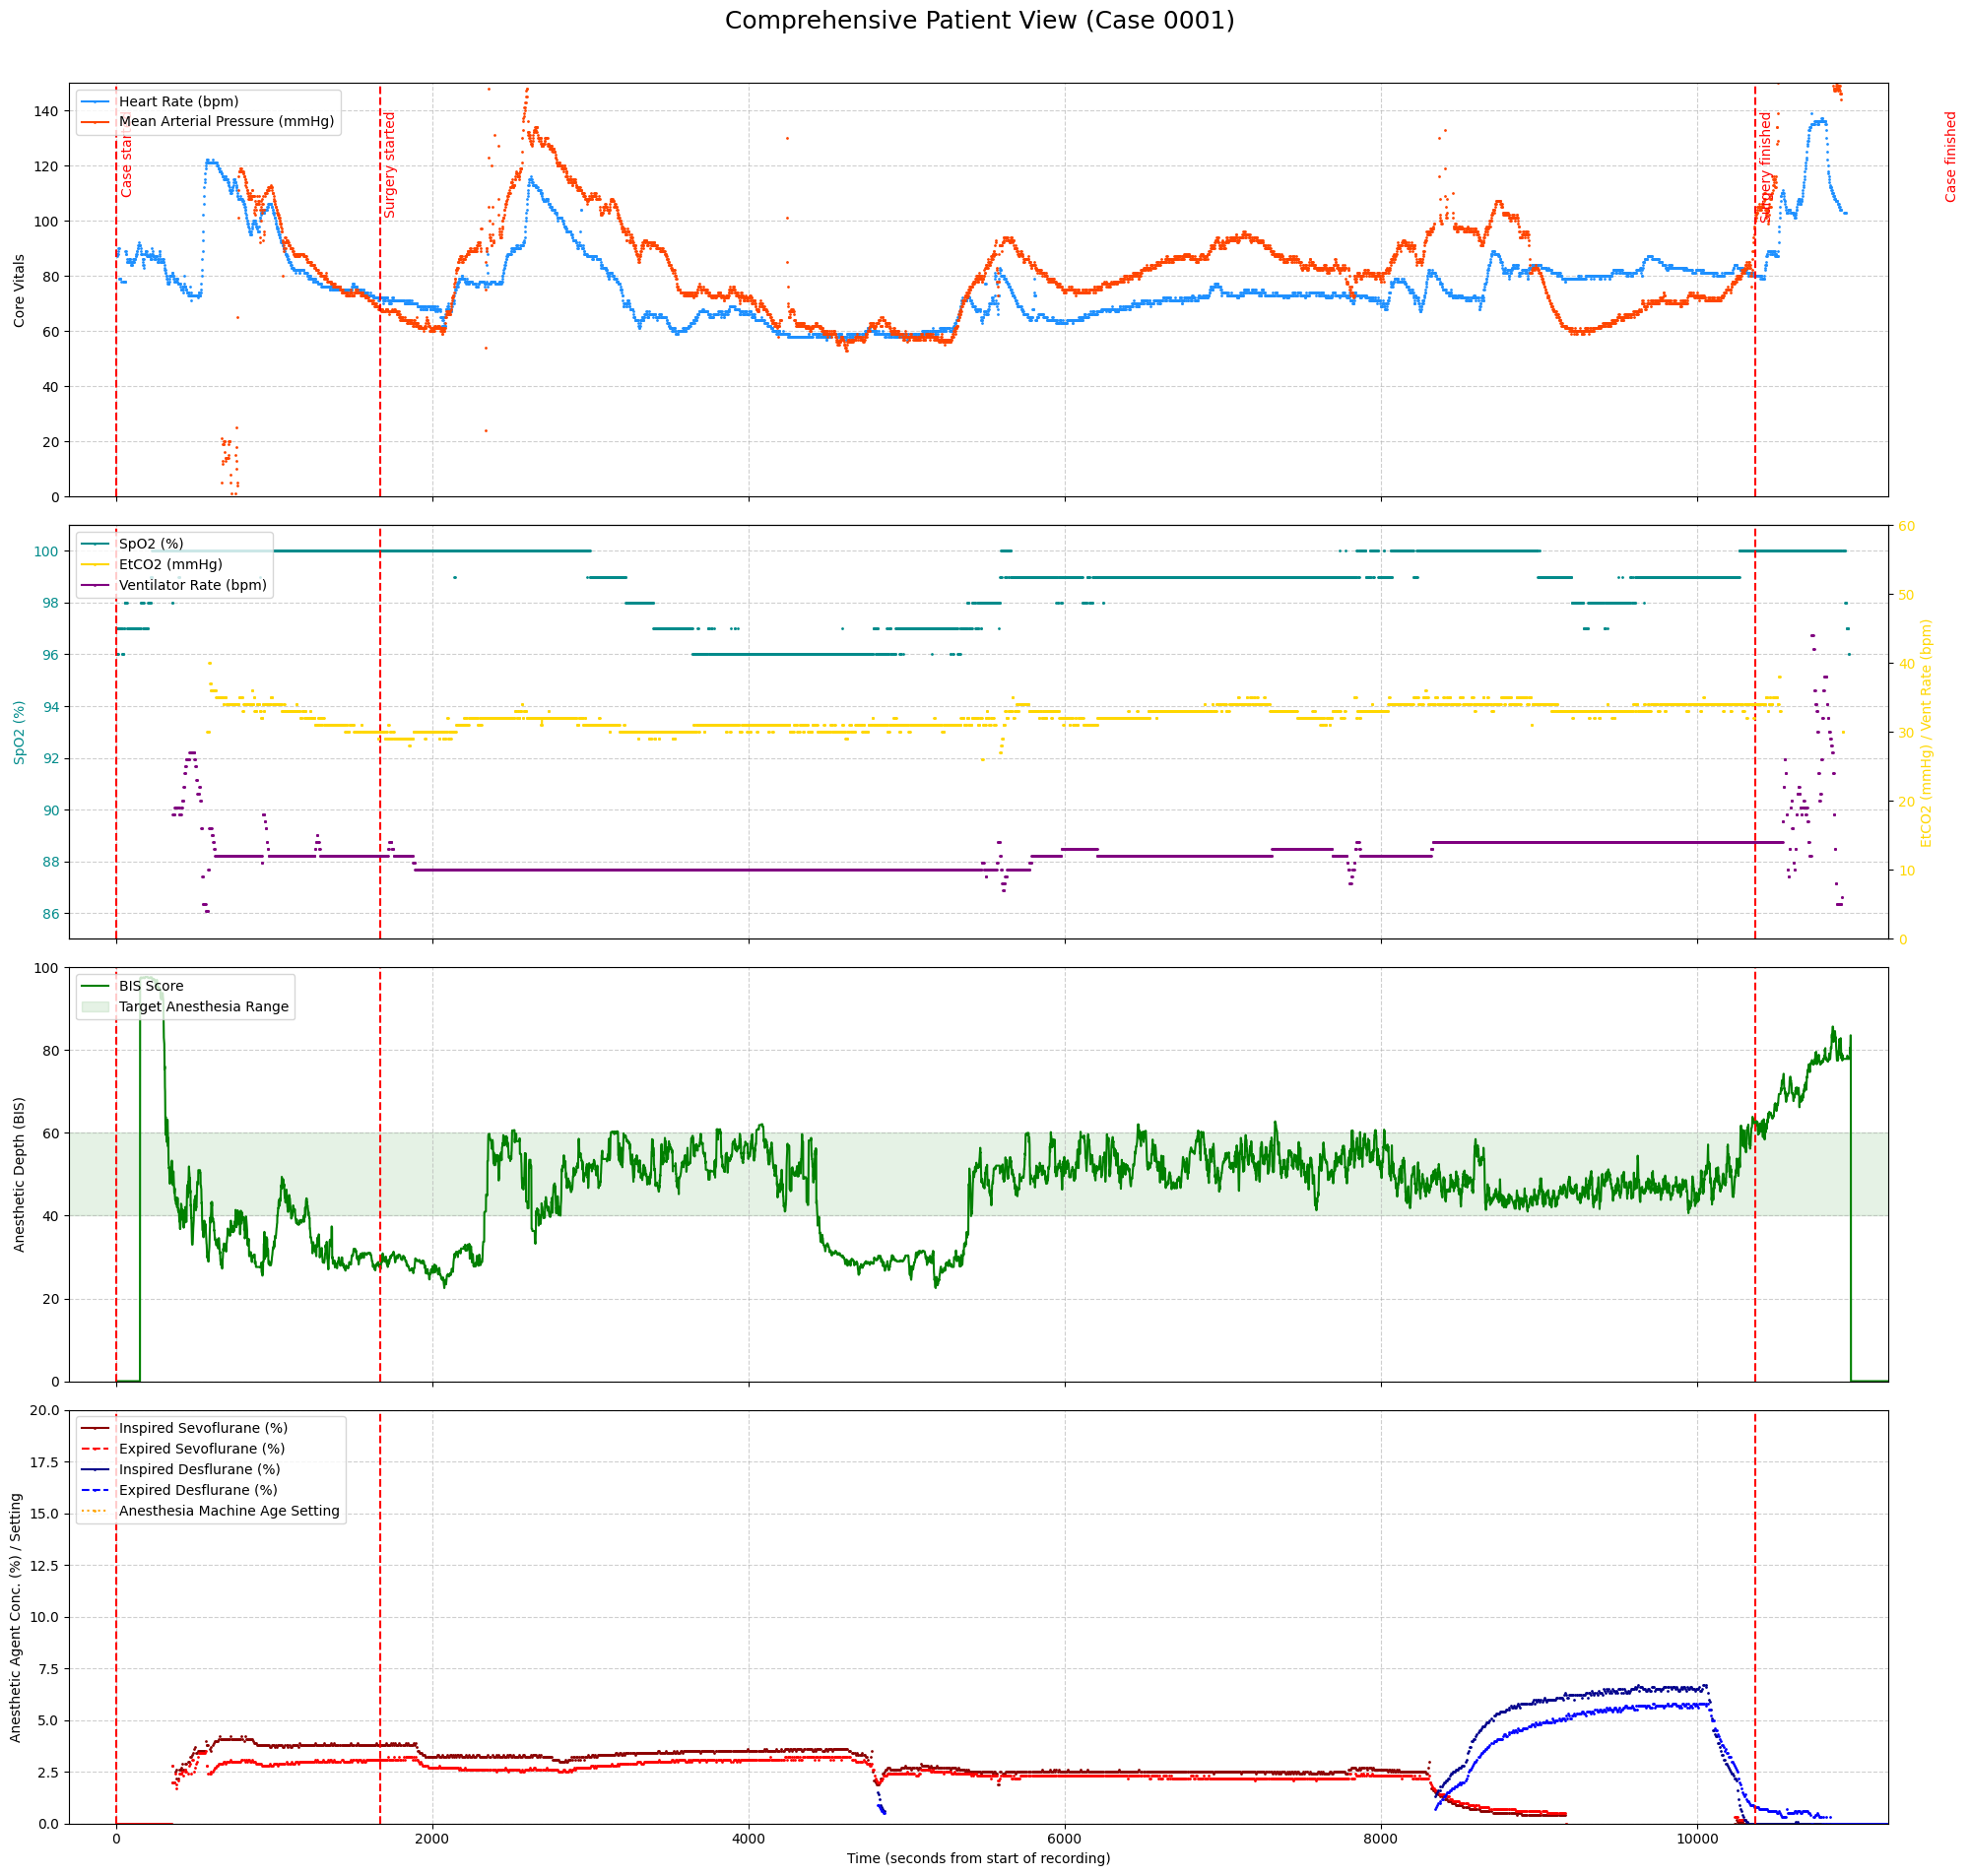

In [9]:
!pip install vitaldb matplotlib awscli --quiet

import vitaldb
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Clean up previous download and re-download the file
!rm -f 0001.vital
!aws s3 cp --no-sign-request s3://physionet-open/vitaldb/1.0.0/vital_files/0001.vital .

file_path = '0001.vital'
if os.path.exists(file_path):
    vf = vitaldb.VitalFile(file_path)

    # Define all tracks to load, including the newly requested ones
    tracks_to_load = [
        'Solar8000/HR',
        'Solar8000/ART_MBP',
        'Solar8000/PLETH_SPO2',
        'Solar8000/ETCO2',
        'Solar8000/VENT_RR',
        'BIS/BIS',
        'Primus/INSP_SEVO',
        'Primus/EXP_SEVO',
        'Primus/INSP_DES',
        'Primus/EXP_DES',
        'Primus/SET_AGE',
        'EVENT'
    ]

    # Load data into a Pandas DataFrame
    df = vf.to_pandas(tracks_to_load, interval=1)

    # Determine the plotting time range
    try:
        # Use ART_MBP as a reference for valid data range
        start_time = df['Solar8000/ART_MBP'].first_valid_index()
        end_time = df['Solar8000/ART_MBP'].last_valid_index()
        if start_time is None or end_time is None: # Fallback if ART_MBP is entirely NaN
            start_time, end_time = df.index.min(), df.index.max()
        print(f"Data found between {start_time} and {end_time} seconds.")
    except (KeyError, TypeError):
        print("Could not find valid data window for ART_MBP. Plotting full range.")
        start_time = df.index.min()
        end_time = df.index.max()

    # Extract events
    events = df['EVENT'].dropna()

    # Create the figure and 4 subplots, sharing the x-axis
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 20), sharex=True)
    fig.suptitle('Comprehensive Patient View (Case 0001)', fontsize=18)

    # --- Subplot 1: Core Vitals (HR, MAP) ---
    ax1.plot(df.index, df['Solar8000/HR'], label='Heart Rate (bpm)', color='dodgerblue', marker='.', markersize=2, linestyle='-')
    ax1.plot(df.index, df['Solar8000/ART_MBP'], label='Mean Arterial Pressure (mmHg)', color='orangered', marker='.', markersize=2, linestyle='-')
    ax1.set_ylabel('Core Vitals')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_ylim(0, 150)

    # --- Subplot 2: Oxygenation and Ventilation (SpO2, EtCO2, VENT_RR) ---
    ax2.plot(df.index, df['Solar8000/PLETH_SPO2'], label='SpO2 (%)', color='darkcyan', marker='.', markersize=2, linestyle='-')
    ax2.set_ylabel('SpO2 (%)', color='darkcyan')
    ax2.tick_params(axis='y', labelcolor='darkcyan')
    ax2.set_ylim(85, 101)

    ax2_twin = ax2.twinx() # Create a twin Y-axis for EtCO2 and VENT_RR
    ax2_twin.plot(df.index, df['Solar8000/ETCO2'], label='EtCO2 (mmHg)', color='gold', marker='.', markersize=2, linestyle='-')
    ax2_twin.plot(df.index, df['Solar8000/VENT_RR'], label='Ventilator Rate (bpm)', color='purple', marker='.', markersize=2, linestyle='-')
    ax2_twin.set_ylabel('EtCO2 (mmHg) / Vent Rate (bpm)', color='gold')
    ax2_twin.tick_params(axis='y', labelcolor='gold')
    ax2_twin.set_ylim(0, 60)

    # Combine legends for ax2 and ax2_twin
    lines, labels = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2_twin.legend(lines + lines2, labels + labels2, loc='upper left')
    ax2.grid(True, linestyle='--', alpha=0.6)

    # --- Subplot 3: Anesthetic Depth (BIS) ---
    ax3.plot(df.index, df['BIS/BIS'], label='BIS Score', color='green')
    ax3.axhspan(40, 60, color='green', alpha=0.1, label='Target Anesthesia Range')
    ax3.set_ylabel('Anesthetic Depth (BIS)')
    ax3.legend(loc='upper left')
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.set_ylim(0, 100)

    # --- Subplot 4: Anesthetic Agents (Sevoflurane, Desflurane, Age Setting) ---
    ax4.plot(df.index, df['Primus/INSP_SEVO'], label='Inspired Sevoflurane (%)', color='darkred', marker='.', markersize=2, linestyle='-')
    ax4.plot(df.index, df['Primus/EXP_SEVO'], label='Expired Sevoflurane (%)', color='red', marker='.', markersize=2, linestyle='--') # Changed to dashed
    ax4.plot(df.index, df['Primus/INSP_DES'], label='Inspired Desflurane (%)', color='darkblue', marker='.', markersize=2, linestyle='-')
    ax4.plot(df.index, df['Primus/EXP_DES'], label='Expired Desflurane (%)', color='blue', marker='.', markersize=2, linestyle='--') # Changed to dashed
    ax4.plot(df.index, df['Primus/SET_AGE'], label='Anesthesia Machine Age Setting', color='orange', marker='.', markersize=2, linestyle=':') # Changed to dotted
    ax4.set_xlabel('Time (seconds from start of recording)')
    ax4.set_ylabel('Anesthetic Agent Conc. (%) / Setting')
    ax4.legend(loc='upper left')
    ax4.grid(True, linestyle='--', alpha=0.6)
    ax4.set_ylim(0, 20)

    # --- Add Event Markers to all subplots ---
    for time, text in events.items():
        for ax in [ax1, ax2, ax3, ax4]:
            ax.axvline(x=time, color='red', linestyle='--', linewidth=1.5)
        ax1.text(time + 30, 140, text, rotation=90, verticalalignment='top', color='red', fontsize=10)

    # Set consistent x-axis limits for all subplots
    ax1.set_xlim(start_time - 300, end_time + 300)

    # Adjust layout to prevent overlapping elements
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

else:
    print(f"ERROR: Download failed. File '{file_path}' not found.")

# Batch Processing and Aggregation for 5 Patients


In [10]:
!pip install vitaldb matplotlib awscli pypdf --quiet

import vitaldb
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

def plot_and_save_patient_data(case_id: int, output_dir: str, pdf_pages: PdfPages):
    """
    Downloads, plots, and saves vital signs data for a single patient to a PDF page.

    Args:
        case_id: The ID of the patient case (e.g., 1 for 0001.vital).
        output_dir: The directory where temporary files might be stored.
        pdf_pages: A PdfPages object to which the generated figure will be added.
    """
    # Format case_id to match filename convention (e.g., 1 -> 0001)
    case_filename = f'{case_id:04d}.vital'
    file_path = os.path.join(output_dir, case_filename)
    s3_path = f's3://physionet-open/vitaldb/1.0.0/vital_files/{case_filename}'

    print(f"Processing Case {case_id}...")

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Download the vital file
    download_command = f'aws s3 cp --no-sign-request {s3_path} {file_path}'
    os.system(download_command)

    if not os.path.exists(file_path):
        print(f"ERROR: Download failed for '{case_filename}'. File not found.")
        return

    try:
        vf = vitaldb.VitalFile(file_path)

        tracks_to_load = [
            'Solar8000/HR',
            'Solar8000/ART_MBP',
            'Solar8000/PLETH_SPO2',
            'Solar8000/ETCO2',
            'Solar8000/VENT_RR',
            'BIS/BIS',
            'Primus/INSP_SEVO',
            'Primus/EXP_SEVO',
            'Primus/INSP_DES',
            'Primus/EXP_DES',
            'Primus/SET_AGE',
            'EVENT'
        ]

        df = vf.to_pandas(tracks_to_load, interval=1)

        # Determine the plotting time range
        start_time, end_time = df.index.min(), df.index.max()
        if 'Solar8000/ART_MBP' in df.columns:
            valid_start = df['Solar8000/ART_MBP'].first_valid_index()
            valid_end = df['Solar8000/ART_MBP'].last_valid_index()
            if valid_start is not None and valid_end is not None:
                start_time = valid_start
                end_time = valid_end
        # Add padding to the time range
        start_time = max(df.index.min(), start_time - 300)
        end_time = min(df.index.max(), end_time + 300)


        events = df['EVENT'].dropna()

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 20), sharex=True)
        fig.suptitle(f'Comprehensive Patient View (Case {case_id:04d})', fontsize=18) # Dynamic title

        # --- Subplot 1: Core Vitals (HR, MAP) ---
        ax1.plot(df.index, df['Solar8000/HR'], label='Heart Rate (bpm)', color='dodgerblue', marker='.', markersize=2, linestyle='-')
        ax1.plot(df.index, df['Solar8000/ART_MBP'], label='Mean Arterial Pressure (mmHg)', color='orangered', marker='.', markersize=2, linestyle='-')
        ax1.set_ylabel('Core Vitals')
        ax1.legend(loc='upper left')
        ax1.grid(True, linestyle='--', alpha=0.6)
        ax1.set_ylim(0, 150)

        # --- Subplot 2: Oxygenation and Ventilation (SpO2, EtCO2, VENT_RR) ---
        ax2.plot(df.index, df['Solar8000/PLETH_SPO2'], label='SpO2 (%)', color='darkcyan', marker='.', markersize=2, linestyle='-')
        ax2.set_ylabel('SpO2 (%)', color='darkcyan')
        ax2.tick_params(axis='y', labelcolor='darkcyan')
        ax2.set_ylim(85, 101)

        ax2_twin = ax2.twinx()
        ax2_twin.plot(df.index, df['Solar8000/ETCO2'], label='EtCO2 (mmHg)', color='gold', marker='.', markersize=2, linestyle='-')
        ax2_twin.plot(df.index, df['Solar8000/VENT_RR'], label='Ventilator Rate (bpm)', color='purple', marker='.', markersize=2, linestyle='-')
        ax2_twin.set_ylabel('EtCO2 (mmHg) / Vent Rate (bpm)', color='gold')
        ax2_twin.tick_params(axis='y', labelcolor='gold')
        ax2_twin.set_ylim(0, 60)

        lines, labels = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_twin.get_legend_handles_labels()
        ax2_twin.legend(lines + lines2, labels + labels2, loc='upper left')
        ax2.grid(True, linestyle='--', alpha=0.6)

        # --- Subplot 3: Anesthetic Depth (BIS) ---
        ax3.plot(df.index, df['BIS/BIS'], label='BIS Score', color='green')
        ax3.axhspan(40, 60, color='green', alpha=0.1, label='Target Anesthesia Range')
        ax3.set_ylabel('Anesthetic Depth (BIS)')
        ax3.legend(loc='upper left')
        ax3.grid(True, linestyle='--', alpha=0.6)
        ax3.set_ylim(0, 100)

        # --- Subplot 4: Anesthetic Agents (Sevoflurane, Desflurane, Age Setting) ---
        ax4.plot(df.index, df['Primus/INSP_SEVO'], label='Inspired Sevoflurane (%)', color='darkred', marker='.', markersize=2, linestyle='-')
        ax4.plot(df.index, df['Primus/EXP_SEVO'], label='Expired Sevoflurane (%)', color='red', marker='.', markersize=2, linestyle='--')
        ax4.plot(df.index, df['Primus/INSP_DES'], label='Inspired Desflurane (%)', color='darkblue', marker='.', markersize=2, linestyle='-')
        ax4.plot(df.index, df['Primus/EXP_DES'], label='Expired Desflurane (%)', color='blue', marker='.', markersize=2, linestyle='--')
        ax4.plot(df.index, df['Primus/SET_AGE'], label='Anesthesia Machine Age Setting', color='orange', marker='.', markersize=2, linestyle=':')
        ax4.set_xlabel('Time (seconds from start of recording)')
        ax4.set_ylabel('Anesthetic Agent Conc. (%) / Setting')
        ax4.legend(loc='upper left')
        ax4.grid(True, linestyle='--', alpha=0.6)
        ax4.set_ylim(0, 20)

        # --- Add Event Markers to all subplots ---
        for time, text in events.items():
            for ax in [ax1, ax2, ax3, ax4]:
                ax.axvline(x=time, color='red', linestyle='--', linewidth=1.5)
            ax1.text(time + 30, 140, text, rotation=90, verticalalignment='top', color='red', fontsize=10)

        ax1.set_xlim(start_time, end_time)

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        pdf_pages.savefig(fig)
        plt.close(fig)
        print(f"Successfully plotted and added Case {case_id} to PDF.")

    except Exception as e:
        print(f"Error processing Case {case_id}: {e}")
    finally:
        # Clean up the downloaded vital file
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Cleaned up '{case_filename}'.")


# --- Main execution for batch processing ---
NUM_PATIENTS = 5 # Set to 100 for full run, 5 for a quick test
OUTPUT_DIR = 'patient_plots'
COMBINED_PDF_FILENAME = 'all_patient_vitals.pdf'

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create a PdfPages object to save all plots into a single PDF
combined_pdf_path = os.path.join(OUTPUT_DIR, COMBINED_PDF_FILENAME)
with PdfPages(combined_pdf_path) as pdf:
    for case_id in range(1, NUM_PATIENTS + 1):
        plot_and_save_patient_data(case_id, OUTPUT_DIR, pdf)

print(f"\nAll plots combined into: {combined_pdf_path}")
print(f"You can find individual vital files downloaded and removed in {OUTPUT_DIR} during processing.")

Processing Case 1...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0001.vital to patient_plots/0001.vital
Successfully plotted and added Case 1 to PDF.
Cleaned up '0001.vital'.
Processing Case 2...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0002.vital to patient_plots/0002.vital
Successfully plotted and added Case 2 to PDF.
Cleaned up '0002.vital'.
Processing Case 3...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0003.vital to patient_plots/0003.vital
Successfully plotted and added Case 3 to PDF.
Cleaned up '0003.vital'.
Processing Case 4...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0004.vital to patient_plots/0004.vital
Successfully plotted and added Case 4 to PDF.
Cleaned up '0004.vital'.
Processing Case 5...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0005.vital to patient_plots/0005.vital
Successfully plotted and added Case 5 to PDF.
Cleaned up '0005.vital'.

All plots combined into: patient_plots/all_patient_vitals.pdf
Yo

# Sevo and des are not helping... 

reverting to an older design while keeping the aesthetic enhancements
and doing it for 100 patients

In [11]:
!pip install vitaldb matplotlib awscli pypdf --quiet

import vitaldb
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

def plot_and_save_patient_data(case_id: int, output_dir: str, pdf_pages: PdfPages):
    """
    Downloads, plots, and saves vital signs data for a single patient to a PDF page.

    Args:
        case_id: The ID of the patient case (e.g., 1 for 0001.vital).
        output_dir: The directory where temporary files might be stored.
        pdf_pages: A PdfPages object to which the generated figure will be added.
    """
    # Format case_id to match filename convention (e.g., 1 -> 0001)
    case_filename = f'{case_id:04d}.vital'
    file_path = os.path.join(output_dir, case_filename)
    s3_path = f's3://physionet-open/vitaldb/1.0.0/vital_files/{case_filename}'

    print(f"Processing Case {case_id}...")

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Download the vital file
    download_command = f'aws s3 cp --no-sign-request {s3_path} {file_path}'
    os.system(download_command)

    if not os.path.exists(file_path):
        print(f"ERROR: Download failed for '{case_filename}'. File not found.")
        return

    try:
        vf = vitaldb.VitalFile(file_path)

        # Define tracks to load - reverted to the original set for the 3-subplot view
        tracks_to_load = [
            'Solar8000/HR',
            'Solar8000/ART_MBP',
            'Solar8000/PLETH_SPO2',
            'Solar8000/ETCO2',
            'BIS/BIS',
            'EVENT'
        ]

        df = vf.to_pandas(tracks_to_load, interval=1)

        # Determine the plotting time range
        start_time, end_time = df.index.min(), df.index.max()
        if 'Solar8000/ART_MBP' in df.columns:
            valid_start = df['Solar8000/ART_MBP'].first_valid_index()
            valid_end = df['Solar8000/ART_MBP'].last_valid_index()
            if valid_start is not None and valid_end is not None:
                start_time = valid_start
                end_time = valid_end
        # Add padding to the time range
        start_time = max(df.index.min(), start_time - 300)
        end_time = min(df.index.max(), end_time + 300)


        events = df['EVENT'].dropna()

        # Create the figure and 3 subplots, sharing the x-axis
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), sharex=True) # Reverted to 3 subplots
        fig.suptitle(f'Comprehensive Patient View (Case {case_id:04d})', fontsize=18) # Dynamic title

        # --- Subplot 1: Core Vitals (HR, MAP) ---
        ax1.plot(df.index, df['Solar8000/HR'], label='Heart Rate (bpm)', color='dodgerblue', marker='.', markersize=2, linestyle='-')
        ax1.plot(df.index, df['Solar8000/ART_MBP'], label='Mean Arterial Pressure (mmHg)', color='orangered', marker='.', markersize=2, linestyle='-')
        ax1.set_ylabel('Core Vitals')
        ax1.legend(loc='upper left')
        ax1.grid(True, linestyle='--', alpha=0.6)
        ax1.set_ylim(0, 150)

        # --- Subplot 2: Oxygenation and Ventilation (SpO2, EtCO2) ---
        ax2.plot(df.index, df['Solar8000/PLETH_SPO2'], label='SpO2 (%)', color='darkcyan', marker='.', markersize=2, linestyle='-')
        ax2.set_ylabel('SpO2 (%)', color='darkcyan')
        ax2.tick_params(axis='y', labelcolor='darkcyan')
        ax2.set_ylim(85, 101)

        ax2_twin = ax2.twinx()
        ax2_twin.plot(df.index, df['Solar8000/ETCO2'], label='EtCO2 (mmHg)', color='gold', marker='.', markersize=2, linestyle='-')
        ax2_twin.set_ylabel('EtCO2 (mmHg)', color='gold') # Reverted label
        ax2_twin.tick_params(axis='y', labelcolor='gold')
        ax2_twin.set_ylim(0, 60)

        # Combine legends for ax2 and ax2_twin
        lines, labels = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_twin.get_legend_handles_labels()
        ax2_twin.legend(lines + lines2, labels + labels2, loc='upper left')
        ax2.grid(True, linestyle='--', alpha=0.6)

        # --- Subplot 3: Anesthetic Depth (BIS) ---
        ax3.plot(df.index, df['BIS/BIS'], label='BIS Score', color='green')
        ax3.axhspan(40, 60, color='green', alpha=0.1, label='Target Anesthesia Range')
        ax3.set_ylabel('Anesthetic Depth (BIS)')
        ax3.legend(loc='upper left')
        ax3.grid(True, linestyle='--', alpha=0.6)
        ax3.set_ylim(0, 100)

        # --- No Subplot 4 for Anesthetic Agents ---

        # --- Add Event Markers to all subplots ---
        for time, text in events.items():
            for ax in [ax1, ax2, ax3]: # Apply to 3 subplots only
                ax.axvline(x=time, color='red', linestyle='--', linewidth=1.5)
            ax1.text(time + 30, 140, text, rotation=90, verticalalignment='top', color='red', fontsize=10)

        ax1.set_xlim(start_time, end_time)

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        pdf_pages.savefig(fig)
        plt.close(fig)
        print(f"Successfully plotted and added Case {case_id} to PDF.")

    except Exception as e:
        print(f"Error processing Case {case_id}: {e}")
    finally:
        # Clean up the downloaded vital file
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Cleaned up '{case_filename}'.")


# --- Main execution for batch processing ---
NUM_PATIENTS = 100 # Set to 100 for full run
OUTPUT_DIR = 'patient_plots'
COMBINED_PDF_FILENAME = 'all_patient_vitals_3_subplots.pdf' # Changed filename to reflect 3 subplots

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create a PdfPages object to save all plots into a single PDF
combined_pdf_path = os.path.join(OUTPUT_DIR, COMBINED_PDF_FILENAME)
with PdfPages(combined_pdf_path) as pdf:
    for case_id in range(1, NUM_PATIENTS + 1):
        plot_and_save_patient_data(case_id, OUTPUT_DIR, pdf)

print(f"\nAll plots combined into: {combined_pdf_path}")
print(f"You can find individual vital files downloaded and removed in {OUTPUT_DIR} during processing.")

Processing Case 1...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0001.vital to patient_plots/0001.vital
Successfully plotted and added Case 1 to PDF.
Cleaned up '0001.vital'.
Processing Case 2...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0002.vital to patient_plots/0002.vital
Successfully plotted and added Case 2 to PDF.
Cleaned up '0002.vital'.
Processing Case 3...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0003.vital to patient_plots/0003.vital
Successfully plotted and added Case 3 to PDF.
Cleaned up '0003.vital'.
Processing Case 4...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0004.vital to patient_plots/0004.vital
Successfully plotted and added Case 4 to PDF.
Cleaned up '0004.vital'.
Processing Case 5...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0005.vital to patient_plots/0005.vital
Successfully plotted and added Case 5 to PDF.
Cleaned up '0005.vital'.
Processing Case 6...
download: s3://physionet-open/vitaldb/1.0.0/

In [12]:
!pip install vitaldb matplotlib awscli pypdf --quiet


In [13]:
import vitaldb
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

def plot_and_save_patient_data(case_id: int, output_dir: str, pdf_pages: PdfPages):
    """
    Downloads, plots, and saves vital signs data for a single patient to a PDF page.

    Args:
        case_id: The ID of the patient case (e.g., 1 for 0001.vital).
        output_dir: The directory where temporary files might be stored.
        pdf_pages: A PdfPages object to which the generated figure will be added.
    """
    # Format case_id to match filename convention (e.g., 1 -> 0001)
    case_filename = f'{case_id:04d}.vital'
    file_path = os.path.join(output_dir, case_filename)
    s3_path = f's3://physionet-open/vitaldb/1.0.0/vital_files/{case_filename}'

    print(f"Processing Case {case_id}...")

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Download the vital file
    download_command = f'aws s3 cp --no-sign-request {s3_path} {file_path}'
    os.system(download_command)

    if not os.path.exists(file_path):
        print(f"ERROR: Download failed for '{case_filename}'. File not found.")
        return

    try:
        vf = vitaldb.VitalFile(file_path)

        # Define tracks to load - reverted to the original set for the 3-subplot view
        tracks_to_load = [
            'Solar8000/HR',
            'Solar8000/ART_MBP',
            'Solar8000/PLETH_SPO2',
            'Solar8000/ETCO2',
            'BIS/BIS',
            'EVENT'
        ]

        df = vf.to_pandas(tracks_to_load, interval=1)

        # Determine the plotting time range
        start_time, end_time = df.index.min(), df.index.max()
        if 'Solar8000/ART_MBP' in df.columns:
            valid_start = df['Solar8000/ART_MBP'].first_valid_index()
            valid_end = df['Solar8000/ART_MBP'].last_valid_index()
            if valid_start is not None and valid_end is not None:
                start_time = valid_start
                end_time = valid_end
        # Add padding to the time range
        start_time = max(df.index.min(), start_time - 300)
        end_time = min(df.index.max(), end_time + 300)


        events = df['EVENT'].dropna()

        # Create the figure and 3 subplots, sharing the x-axis
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), sharex=True) # Reverted to 3 subplots
        fig.suptitle(f'Comprehensive Patient View (Case {case_id:04d})', fontsize=18) # Dynamic title

        # --- Subplot 1: Core Vitals (HR, MAP) ---
        ax1.plot(df.index, df['Solar8000/HR'], label='Heart Rate (bpm)', color='dodgerblue', marker='.', markersize=2, linestyle='-')
        ax1.plot(df.index, df['Solar8000/ART_MBP'], label='Mean Arterial Pressure (mmHg)', color='orangered', marker='.', markersize=2, linestyle='-')
        ax1.set_ylabel('Core Vitals')
        ax1.legend(loc='upper left')
        ax1.grid(True, linestyle='--', alpha=0.6)
        ax1.set_ylim(0, 150)

        # --- Subplot 2: Oxygenation and Ventilation (SpO2, EtCO2) ---
        ax2.plot(df.index, df['Solar8000/PLETH_SPO2'], label='SpO2 (%)', color='darkcyan', marker='.', markersize=2, linestyle='-')
        ax2.set_ylabel('SpO2 (%)', color='darkcyan')
        ax2.tick_params(axis='y', labelcolor='darkcyan')
        ax2.set_ylim(85, 101)

        ax2_twin = ax2.twinx()
        ax2_twin.plot(df.index, df['Solar8000/ETCO2'], label='EtCO2 (mmHg)', color='gold', marker='.', markersize=2, linestyle='-')
        ax2_twin.set_ylabel('EtCO2 (mmHg)', color='gold') # Reverted label
        ax2_twin.tick_params(axis='y', labelcolor='gold')
        ax2_twin.set_ylim(0, 60)

        # Combine legends for ax2 and ax2_twin
        lines, labels = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_twin.get_legend_handles_labels()
        ax2_twin.legend(lines + lines2, labels + labels2, loc='upper left')
        ax2.grid(True, linestyle='--', alpha=0.6)

        # --- Subplot 3: Anesthetic Depth (BIS) ---
        ax3.plot(df.index, df['BIS/BIS'], label='BIS Score', color='green')
        ax3.axhspan(40, 60, color='green', alpha=0.1, label='Target Anesthesia Range')
        ax3.set_ylabel('Anesthetic Depth (BIS)')
        ax3.legend(loc='upper left')
        ax3.grid(True, linestyle='--', alpha=0.6)
        ax3.set_ylim(0, 100)

        # --- No Subplot 4 for Anesthetic Agents ---

        # --- Add Event Markers to all subplots ---
        for time, text in events.items():
            for ax in [ax1, ax2, ax3]: # Apply to 3 subplots only
                ax.axvline(x=time, color='red', linestyle='--', linewidth=1.5)
            ax1.text(time + 30, 140, text, rotation=90, verticalalignment='top', color='red', fontsize=10)

        ax1.set_xlim(start_time, end_time)

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        pdf_pages.savefig(fig)
        plt.close(fig)
        print(f"Successfully plotted and added Case {case_id} to PDF.")

    except Exception as e:
        print(f"Error processing Case {case_id}: {e}")
    finally:
        # Clean up the downloaded vital file
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Cleaned up '{case_filename}'.")


# --- Main execution for batch processing ---
NUM_PATIENTS = 100 # Set to 100 for full run
OUTPUT_DIR = 'patient_plots'
COMBINED_PDF_FILENAME = 'all_patient_vitals_3_subplots.pdf' # Changed filename to reflect 3 subplots

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create a PdfPages object to save all plots into a single PDF
combined_pdf_path = os.path.join(OUTPUT_DIR, COMBINED_PDF_FILENAME)
with PdfPages(combined_pdf_path) as pdf:
    for case_id in range(1, NUM_PATIENTS + 1):
        plot_and_save_patient_data(case_id, OUTPUT_DIR, pdf)

print(f"\nAll plots combined into: {combined_pdf_path}")
print(f"You can find individual vital files downloaded and removed in {OUTPUT_DIR} during processing.")

Processing Case 1...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0001.vital to patient_plots/0001.vital
Successfully plotted and added Case 1 to PDF.
Cleaned up '0001.vital'.
Processing Case 2...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0002.vital to patient_plots/0002.vital
Successfully plotted and added Case 2 to PDF.
Cleaned up '0002.vital'.
Processing Case 3...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0003.vital to patient_plots/0003.vital
Successfully plotted and added Case 3 to PDF.
Cleaned up '0003.vital'.
Processing Case 4...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0004.vital to patient_plots/0004.vital
Successfully plotted and added Case 4 to PDF.
Cleaned up '0004.vital'.
Processing Case 5...
download: s3://physionet-open/vitaldb/1.0.0/vital_files/0005.vital to patient_plots/0005.vital
Successfully plotted and added Case 5 to PDF.
Cleaned up '0005.vital'.
Processing Case 6...
download: s3://physionet-open/vitaldb/1.0.0/